# Imports

In [6]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as Layer
import numpy as np
import tensorflow.keras.layers.experimental.preprocessing as preprocessing
from DatasetFormatting import *
import statistics


# Preparing Training Dataset

In [7]:
np.random.seed(1)
tf.random.set_seed(1)

movie_df = getData()
movie_df.drop(['vote_count'], axis = 1)

data_count = movie_df.shape[0]
training_data_count = int(data_count * 0.75) + 1
test_data_count = data_count - training_data_count

y_train = np.array(movie_df['vote_average'].head(training_data_count))
x_train = np.array(movie_df['training_col'].head(training_data_count))

y_test = np.array(movie_df['vote_average'].tail(test_data_count))
x_test = np.array(movie_df[['training_col']].tail(test_data_count))

std = statistics.stdev(movie_df['vote_average'].to_list())
mean = statistics.mean(movie_df['vote_average'].to_list())
variance = statistics.variance(movie_df['vote_average'].to_list())
mode = statistics.mode(movie_df['vote_average'].to_list())

print(f"STD: {std}")
print(f"mean: {mean}")
print(f"variance: {variance}")
print(f"mode: {mode}")

# print(x_train)
print(f"x_train shape: {x_train.shape}")

STD: 0.9976277124059775
mean: 6.165617412034789
variance: 0.9952610525603838
mode: 6.5
x_train shape: (16989,)


### Text Vectorization For Actors & Genres

In [ ]:
VOCAB_SIZE = 201277
encoder = preprocessing.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=6)
features = np.array(movie_df['training_col'])
encoder.adapt(features)

# this line of code doesnt work on windows for some reason
# print(np.array(encoder.get_vocabulary()))

### Text Vectorization Sanity Check

In [ ]:
print(movie_df['training_col'].to_numpy()[0])
x = encoder(movie_df['training_col'].to_numpy()[0]).numpy()
x

<br><br><br><br><br><br><br><br><br><br>
# Feed Forward Neural Network

### Building The FFNN

In [ ]:
model_FFNN = tf.keras.Sequential([
encoder,
    Layer.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=500),
    Layer.Flatten(input_shape=(16989, 1)),
    Layer.Dense(56, activation='tanh'),
    Layer.Dense(125, activation='tanh'),
    Layer.Dense(104, activation='tanh'),
    Layer.Dense(120, activation='tanh'),
    Layer.Dense(1)
])

model_FFNN.summary()

model_FFNN.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.RMSprop(.001))




### Training The FFNN

In [ ]:
model_FFNN.fit(
    x_train,
    y_train, 
    batch_size=256,
    epochs=1,
    verbose=1)

score = model_FFNN.evaluate(x_test, y_test)
print('Test loss:', score)

### Validating FFNN On **Train** Data

In [ ]:
def print_train_prediction_ffnn(index):
    print(f"Prediction for index: {index}")
    
    print(f"input ---> {x_train[index]}")
    print(f"actual output ---> {y_train[index]}")
    print(f"predicted output ---> {model_FFNN.predict(x_test[index])}\n")

print_train_prediction_ffnn(0)
print_train_prediction_ffnn(1)
print_train_prediction_ffnn(2)
print_train_prediction_ffnn(3)
print_train_prediction_ffnn(4)

### Validating FFNN On **Test** Data

In [ ]:
def print_test_prediction_ffnn(index):
    print(f"Prediction for index: {index}")
    
    print(f"input ---> {x_test[index]}")
    print(f"actual output ---> {y_test[index]}")
    print(f"predicted output ---> {model_FFNN.predict(x_test[index])}\n")
        
print_test_prediction_ffnn(0)
print_test_prediction_ffnn(1)
print_test_prediction_ffnn(2)
print_test_prediction_ffnn(3)
print_test_prediction_ffnn(4)

<br><br><br><br><br><br><br><br><br><br>

# Recurrent Neural Network

### Building The RNN

In [ ]:
model_RNN = tf.keras.Sequential([
encoder,
    Layer.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=400),
    Layer.SimpleRNN(200, activation='selu'),
    Layer.Dense(60,activation='selu'),
    Layer.Dense(20,activation='selu'),
    Layer.Dense(60,activation='selu'),
    Layer.Dense(80,activation='selu'),
    Layer.Dense(1)
])

model_RNN.summary()

model_RNN.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.RMSProp(1e-4))

### Training The RNN

In [ ]:
model_RNN.fit(
    x_train,
    y_train, 
    batch_size=256,
    epochs=5,
    verbose=5)

score = model_RNN.evaluate(x_test, y_test)
print('Test loss:', score)

### Validating RNN On **Train** Data

In [ ]:
def print_train_prediction_rnn(index):
    print(f"Prediction for index: {index}")
    
    print(f"input ---> {x_train[index]}")
    print(f"actual output ---> {y_train[index]}")
    print(f"predicted output ---> {model_RNN.predict(x_test[index])}\n")

print_train_prediction_rnn(0)
print_train_prediction_rnn(1)
print_train_prediction_rnn(2)
print_train_prediction_rnn(3)
print_train_prediction_rnn(4)


### Validating RNN On **Test** Data

In [ ]:
def print_test_prediction_rnn(index):
    print(f"Prediction for index: {index}")
    
    print(f"input ---> {x_test[index]}")
    print(f"actual output ---> {y_test[index]}")
    print(f"predicted output ---> {model_RNN.predict(x_test[index])}\n")
        
print_test_prediction_rnn(0)
print_test_prediction_rnn(1)
print_test_prediction_rnn(2)
print_test_prediction_rnn(3)
print_test_prediction_rnn(4)

In [ ]:
# print(df.loc[df['title'] == 'Sully']['vote_average'])

# sully_input = 'TomHanks AaronEckhart LauraLinney AnnaGunn AutumnReeser Drama'
# validation_prediction = model_FFNN.predict(np.array([sully_input]))
# print(validation_prediction[0])

<br><br><br><br><br>
# Niave Bayes Model

In [10]:
from sklearn.model_selection import train_test_split
import sklearn.naive_bayes as NB
import matplotlib.pyplot as plot

Total Correct Ratio: 14759/16989
0.8687385955618341


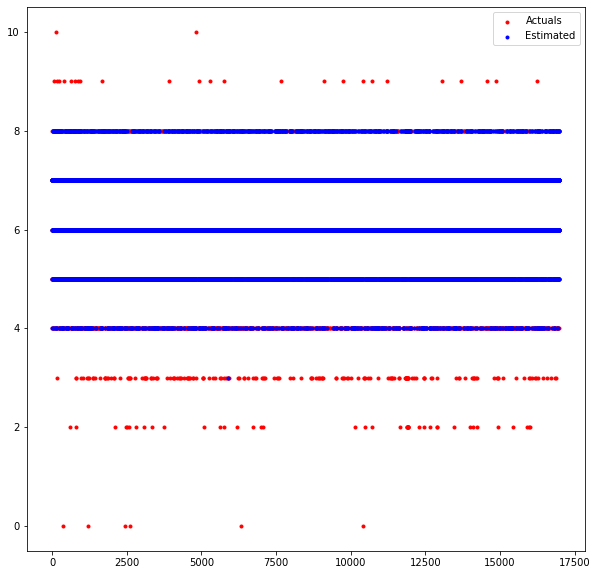

In [13]:
def naiveBayes(X, y):
 NBmodel = NB.CategoricalNB()
 NBmodel = NBmodel.fit(X, y)
 return NBmodel


def prepareForNB(data):
  all_actors = data['cast'].to_list()
  genres = data['genres'].to_list()

  X = []
  unique_keys = {'': 0}
  unique_key = 1

  for i in range(0, len(all_actors)):
    row = []

    raw_row = all_actors[i].split()
    raw_row.insert(0, genres[i])
    if len(raw_row) < 6:
      for i in range(0, 6 - len(raw_row)):
        raw_row.append('')

    for item in raw_row:
      if item not in unique_keys:
        unique_keys[item] = unique_key
        unique_key += 1
      row.append(unique_keys[item])

    X.append(row)
  
  genres = data['genres'].to_list()

  ratings = data['vote_average'].to_list()
  for i in range(0, len(ratings)):
    ratings[i] = round(ratings[i])

  return X, ratings



X, ratings = prepareForNB(movie_df)

data_count = movie_df.shape[0]
training_data_count = int(data_count * 0.75) + 1
test_data_count = data_count - training_data_count

nb_y_train = np.array(ratings[0:training_data_count])
nb_x_train = np.array(X[0:training_data_count])

nb_y_test = np.array(ratings[:-1 * test_data_count])
nb_x_test = np.array(X[:-1 * test_data_count])

NBmodel = naiveBayes(nb_x_train, nb_y_train)

y_pred = NBmodel.predict(nb_x_test)

total_correct = 0
for i in range(0, nb_y_test.shape[0]):
  if int(y_pred[i]) == nb_y_test[i]:
    total_correct += 1

test_size = nb_y_test.shape[0]
accuracy = total_correct/test_size
print(f"Total Correct Ratio: {total_correct}/{nb_y_test.shape[0]}")
print(accuracy)

plot.figure(figsize = [10, 10])
actuals = plot.scatter(np.linspace(0, test_size, test_size), nb_y_test, color='red', marker='.')
estimates = plot.scatter(np.linspace(0, test_size, test_size), y_pred, color='blue', marker='.')
plot.legend([actuals, estimates], ["Actuals", "Estimated"])
plot.show()